In [1]:
# Open CV

In [1]:
from matplotlib import pyplot as plt
import cv2
from IPython.display import display, Image, clear_output
import os
import cv_helper
from filter_to_motion import *
import pixellib
from pixellib.semantic import semantic_segmentation

2021-09-05 15:12:01.371492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-05 15:12:01.371621: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-09-05 15:12:02.973324: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-05 15:12:02.975553: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-05 15:12:02.975599: W tensorflow/stream_ex

In [2]:
class remove_background:
    def __init__(self, base_filename, in_fps=30):
        self.base_filename = base_filename
        self.in_fps = in_fps
        self.debug_window_refresh_rate = int(
            self.in_fps / 2
        )  # every 0.5 seconds; TODO Compute
        pass

    def create(self, input_video):
        self.state = FrameState(0, 0)

    def destroy(self):
        pass

    def frame(self, idx, original_frame):
        self.state.idx = idx

        # PERF: Processing at 1/4 size boosts FPS by TK%
        in_frame = shrink_image_half(original_frame)

        # PERF: Motion Mask sampled frames
        motion_mask = to_motion_mask_fast(self.state, in_frame)

        # skip frames with no motion
        if is_frame_black(motion_mask):
            return

        # PERF - show_debug_window at on sampled frames
        if idx % self.debug_window_refresh_rate == 0:
            debug_frame = create_analyze_debug_frame(in_frame, motion_mask)
            burn_in_debug_info(debug_frame, idx, self.in_fps)
            masked_input = cv2.bitwise_and(in_frame, in_frame, mask=motion_mask)
            cv_helper.display_jupyter(masked_input)

In [6]:
input_video_path = "~/downloads/igor-magic.mp4"
ic(input_video_path)

ic| input_video_path: '~/downloads/igor-magic.mp4'


'~/downloads/igor-magic.mp4'

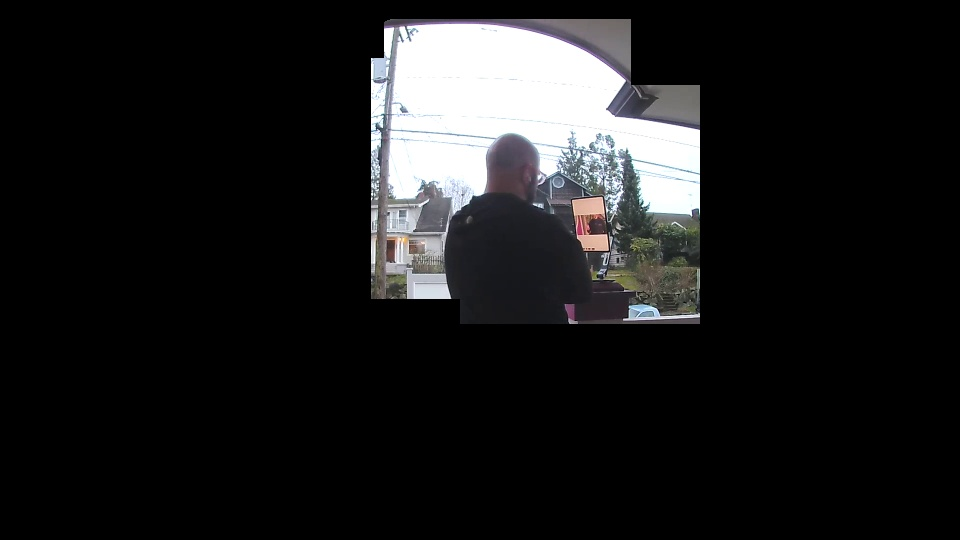

ic| int(fps.fps()): 91, int(fps.elapsed()): 10


In [7]:
rb = remove_background(input_video_path, 30)
cv_helper.process_video(cv_helper.cv2_video(input_video_path), rb)

In [13]:
segment_frame = semantic_segmentation()
segment_frame.load_ade20k_model(
    os.path.expanduser("~/downloads/deeplabv3_xception65_ade20k.h5")
)

In [41]:
class segment:
    def __init__(self, segmenter, in_fps=30):
        self.segmenter = segmenter  # expensive to initate, cache it.
        self.in_fps = in_fps
        self.debug_window_refresh_rate = int(
            self.in_fps / 2
        )  # every 0.5 seconds; TODO Compute
        pass

    def create(self, input_video):
        pass

    def destroy(self):
        pass

    def frame(self, idx, frame):
        if idx % self.in_fps * 5:
            ret, img = self.segmenter.segmentFrameAsAde20k(frame, overlay=True)
            cv_helper.display_jupyter(img)
            ic(ret.keys())
            ic(ret["class_ids"])
            ic(len(ret["masks"]))
            ic(len(ret["masks"][0]))
            ic(len(ret["masks"][1]))
            ic(len(ret["masks"][2]))
            ic(ret["masks"][14])

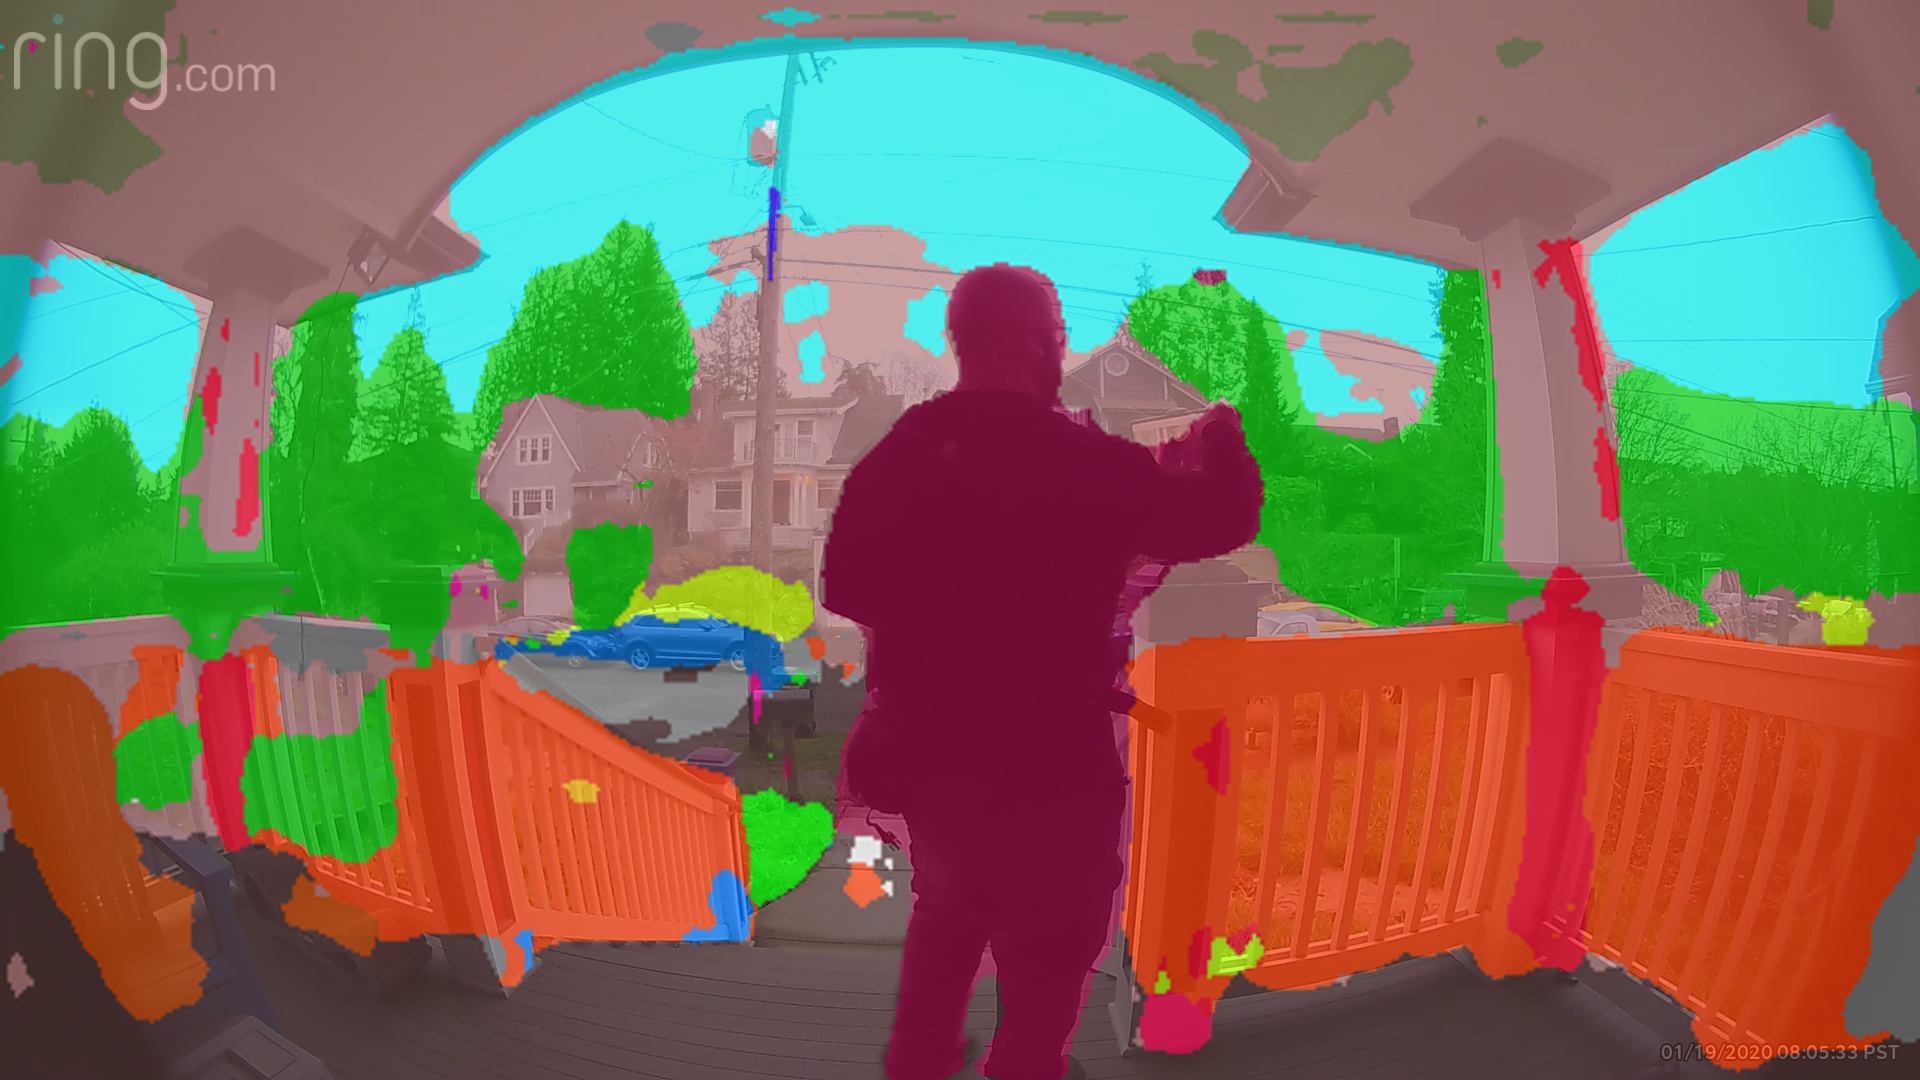

ic| ret.keys(): dict_keys(['class_ids', 'masks'])
ic| ret["class_ids"]: array([  1,   2,   3,   4,   5,   6,   7,   9,  10,  13,  16,  18,  20,
                              21,  23,  33,  39,  43,  44,  88,  94,  96, 145])
ic| len(ret["masks"]): 1080
ic| len(ret["masks"][0]): 1920
ic| len(ret["masks"][1]): 1920
ic| len(ret["masks"][2]): 1920
ic| ret["masks"][14]: array([ True,  True,  True, ...,  True,  True,  True])


In [ ]:
rb = segment(segment_frame, 30)
cv_helper.process_video(cv_helper.cv2_video(input_video_path), rb)